In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot
from sklearn.model_selection import train_test_split

In [2]:
import sklearn
import os

# step1.  prepare for data

In [3]:
sample_lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        sample_lines.append(line)

In [4]:

from sklearn.model_selection import train_test_split
from skimage import transform as transf
from sklearn.utils import shuffle

train_samples, validation_samples = train_test_split(sample_lines, test_size=0.2)
print("len of train_samples={},validation_sample={}".format(len(train_samples),len(validation_samples)))

len of train_samples=4027,validation_sample=1007


# step2: augment data

1.clip image
2.use left and right camera data

### to generate data for training rather than storing the training data in memory.

In [5]:
def generator(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                #image_count*3
                for i in range(3):
                    filename = batch_sample[i].split('/')[-1]
                    current_path = './data/IMG/'+filename
                    #center_image = cv2.imread(name)
                    #center_angle = float(batch_sample[3])
                    center_image=matplotlib.pyplot.imread(current_path)
                    
                    #calibration,left+0.2,right-0.2
                    center_angle = -0.3*i*i+0.5*i + float(batch_sample[3])
                    images.append(center_image)
                    angles.append(center_angle)
            #argment clip image_count*2
            augmented_images,augmentd_measurements=[],[]
            for image,measurement in zip(images,angles):
                augmented_images.append(image)
                augmentd_measurements.append(measurement)
                
                augmented_images.append(cv2.flip(image,1))
                augmentd_measurements.append(measurement*(-1.0))
                # trim image to only see section with road
            #print("len of augmented_images={},augmentd_measurements={}".format(len(augmented_images),len(augmentd_measurements)))

            X_train = np.array(augmented_images)
            y_train = np.array(augmentd_measurements)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda,Cropping2D
from keras.layers.core import Dense, Activation, Flatten,Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [7]:
# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

# step3: design the Net Architecture

use the Net Architecture by NVIDA'S autonomous vehicle team

In [8]:
model = Sequential()

#normalizing and mean centering the data
model.add(Lambda(lambda x: x/255.0-0.5,input_shape=(160,320,3)))

#crop the dirty data
model.add(Cropping2D(cropping=((50,20),(0,0))))

#using the Net architecture published by the autonomous vehicle team at NVIDIA
model.add(Convolution2D(filters=24,kernel_size=(5,5),strides=(2,2), activation='relu', name='conv1_1'))
model.add(Dropout(0.5))
model.add(Convolution2D(filters=36,kernel_size=(5,5),strides=(2,2), activation='relu', name='conv1_2'))
model.add(Convolution2D(filters=48,kernel_size=(5,5),strides=(2,2), activation='relu', name='conv1_3'))

model.add(Convolution2D(filters=64,kernel_size=(3,3),strides=(2,2), activation='relu', name='conv2_1'))
model.add(Convolution2D(filters=64,kernel_size=(3,3),strides=(2,2), activation='relu', name='conv2_2'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# step4, train

In [9]:
from datetime import  datetime

epoch_start = datetime.now()

model.compile(loss='mse',optimizer='adam')
#model.fit(X_train,y_train,validation_split=0.2,shuffle=True,epochs=20)
history_object = model.fit_generator(train_generator, \
            steps_per_epoch=math.ceil(len(train_samples)/batch_size), \
            validation_data=validation_generator, \
            validation_steps=math.ceil(len(validation_samples)/batch_size), \
            epochs=30, verbose=1)
delta = datetime.now()-epoch_start

print("Train model elapsed time:{}(s)".format(delta.seconds))

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
126/126 [==============================] - 88s 697ms/step - loss: 0.0277 - val_loss: 0.0214
Epoch 2/30
126/126 [==============================] - 81s 645ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 3/30
126/126 [==============================] - 83s 656ms/step - loss: 0.0183 - val_loss: 0.0171
Epoch 4/30
126/126 [==============================] - 82s 653ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 5/30
126/126 [==============================] - 82s 651ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 6/30
126/126 [==============================] - 82s 654ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 7/30
126/126 [==============================] - 83s 656ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 8/30
126/126 [==============================] - 83s 656ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 9/30
126/126 [==============================] - 84s 665ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 10/30
116/126 [====

KeyboardInterrupt: 

### save keras's model

In [11]:
model.save('model.h5')
X_train=[]
y_train=[]
images=[]
measurements=[]

dict_keys(['val_loss', 'loss'])


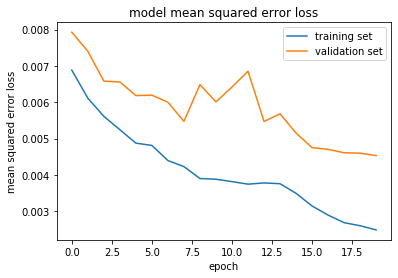

In [13]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig("examples/error_loss.png")
plt.show()